In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# import data

X_train = pd.read_csv("Project_materials/ais_train.csv", delimiter='|')
X_test = pd.read_csv("Project_materials/ais_train.csv", delimiter='|')
vessels = pd.read_csv("Project_materials/vessels.csv", delimiter='|')
ports = pd.read_csv("Project_materials/ports.csv", delimiter='|')
schedules = pd.read_csv("Project_materials/schedules_to_may_2024.csv", delimiter='|')


In [3]:
X_train.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3


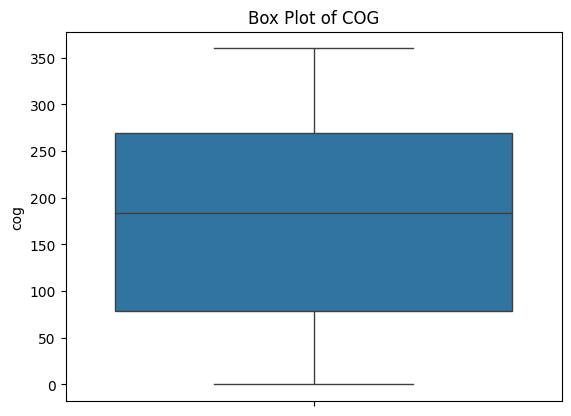

not available (equal to 360):  5858
anomalous (greater then 360):  0
CONTROL (must be zero):  0
CONTROL (must be zero):  0


In [4]:
#PRE-PROCESSING
df = X_train.copy()
#COG
sns.boxplot(y=X_train['cog'])
plt.title('Box Plot of COG')
plt.show()

cog_not_available = (X_train['cog'] == 360).sum()
cog_anomalous = (X_train['cog'] > 360).sum()

print("not available (equal to 360): ", cog_not_available)
print("anomalous (greater then 360): ", cog_anomalous)

df.loc[df['cog']>=360, 'cog'] = np.nan

cog_not_available_df = (df['cog'] == 360).sum()
cog_anomalous_df = (df['cog'] > 360).sum()

print("CONTROL (must be zero): ", cog_not_available_df)
print("CONTROL (must be zero): ", cog_anomalous_df)



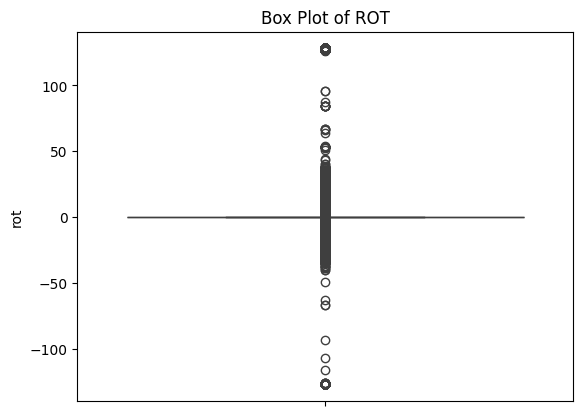

not available (== -128):  0
turning right slowly ( == 127):  11339
turning left slowly (== -127):  11042
CONTROL (must be zero):  0
CONTROL (must be zero):  0


In [5]:
# ROT
sns.boxplot(y=X_train['rot'])
plt.title('Box Plot of ROT')
plt.show()

rot_right = (X_train['rot'] == 127).sum()
rot_left = (X_train['rot'] == -127).sum()
rot_unknown = (X_train['rot'] == -128).sum()

print("not available (== -128): ", rot_unknown)
print("turning right slowly ( == 127): ", rot_right)
print("turning left slowly (== -127): ", rot_left)

#new feature: 
#  - if rot is present the value is zero
#  - if rot is not present and it's turning right slowly +1
#  - if rot is not present and it's turning left slowly -1


df['slow_turn'] = 0
df.loc[df['rot']==127, 'slow_turn'] = 1
df.loc[df['rot']==-127, 'slow_turn'] = -1

# cleaning rot from beforementioned flags
df.loc[df['rot']==127, 'rot'] = np.nan
df.loc[df['rot']<=-127, 'rot'] = np.nan


rot_right_check = (df['rot'] == 127).sum()
rot_left_check = (df['rot'] == -127).sum()
print("CONTROL (must be zero): ", rot_right_check)
print("CONTROL (must be zero): ", rot_left_check)

navstat:  5
navstat_not_defined:  670


<Axes: xlabel='navstat', ylabel='count'>

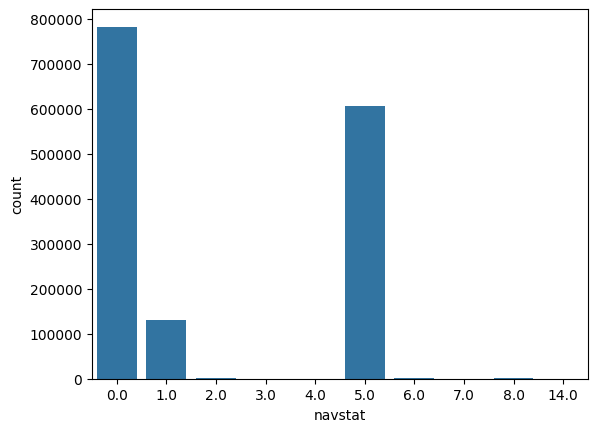

In [6]:
# NAVSTAT
classes_to_be_removed = df['navstat'].isin([9,10,11,12,13]).sum()
print("navstat: ", classes_to_be_removed)
navstat_not_defined = (X_train['navstat'] == 15).sum()
print("navstat_not_defined: ", navstat_not_defined)

df.loc[df['navstat'].isin([9, 10, 11, 12, 13]), 'navstat'] = np.nan
df.loc[df['navstat'] == 15] = np.nan

sns.countplot(x='navstat', data=df)

#TODO: use iterative imputer here

In [7]:
# latitude
anomalous_latitude = (X_train['latitude'] > 90).sum() + (X_train['latitude'] < -90).sum()
print("anomalous_latitude: ", anomalous_latitude)




anomalous_latitude:  0


In [8]:
# vesselid
vessels.count()
df['vesselId'].nunique()

688

In [9]:
#merging all datasets

df = pd.merge(df, vessels, on='vesselId', how='left')
df = pd.merge(df, ports, on='portId', how='left')

df = df.drop(columns=['vesselId','portId'])

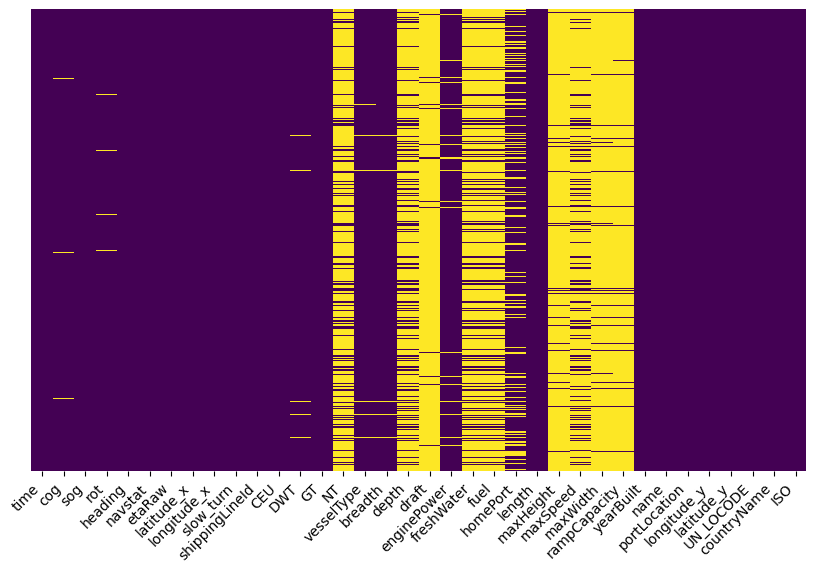

In [10]:
nan_mask = df.isna()
plt.figure(figsize=(10, 6)) 
sns.heatmap(nan_mask, cmap='viridis', cbar=False, yticklabels=False)
# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)

plt.show()

In [11]:
df_without_time = df.drop(columns=['time', 'etaRaw', 'shippingLineId', 'name', 'homePort', 'portLocation', 'UN_LOCODE', 'countryName','ISO', 'NT', 'depth', 'draft', 'freshWater', 'fuel', 'maxHeight', 'maxSpeed', 'maxWidth', 'rampCapacity'])
df_without_time.head()

,cog,sog,rot,heading,navstat,latitude_x,longitude_x,slow_turn,CEU,DWT,GT,vesselType,breadth,enginePower,length,yearBuilt,longitude_y,latitude_y
0,284.0,0.7,0.0,88.0,0.0,-34.74370,-57.85130,0.0,6500.0,21214.0,57718.0,83.0,32.00,0.0,199.00,2004.0,-71.618889,-33.5875
1,109.6,0.0,-6.0,347.0,1.0,8.89440,-79.47939,0.0,5174.0,18878.0,59583.0,83.0,32.26,15100.0,199.97,2012.0,-79.533000,8.9670
2,111.0,11.0,0.0,112.0,0.0,39.19065,-76.47567,0.0,6402.0,18383.0,59217.0,83.0,32.00,0.0,199.00,2005.0,-76.558889,39.2325
3,96.4,0.0,0.0,142.0,1.0,-34.41189,151.02067,0.0,5849.0,15199.0,55598.0,83.0,32.00,0.0,199.00,1995.0,150.899444,-34.4625
4,214.0,19.7,0.0,215.0,0.0,35.88379,-5.91636,0.0,5219.0,18833.0,58939.0,83.0,32.20,15130.0,199.95,2010.0,-5.817000,35.7830


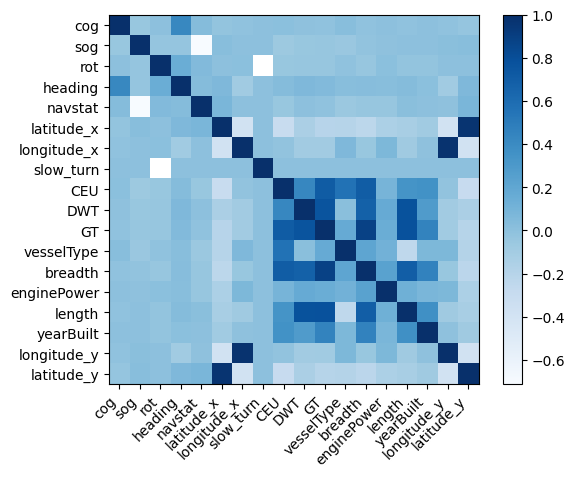

In [12]:
matrix = df_without_time.corr()

plt.imshow(matrix, cmap='Blues')
plt.colorbar()
variables = []
for i in matrix.columns:
    variables.append(i)

# Adding labels to the matrix
plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)

# Display the plot
plt.show()

In [13]:
df.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude_x,longitude_x,slow_turn,...,maxWidth,rampCapacity,yearBuilt,name,portLocation,longitude_y,latitude_y,UN_LOCODE,countryName,ISO
0,2024-01-01 00:00:25,284.0,0.7,0.0,88.0,0.0,01-09 23:00,-34.74370,-57.85130,0.0,...,NaN,NaN,2004.0,Puerto San Antonio,San Antonio,-71.618889,-33.5875,CLSAI,Chile,CL
1,2024-01-01 00:00:36,109.6,0.0,-6.0,347.0,1.0,12-29 20:00,8.89440,-79.47939,0.0,...,NaN,NaN,2012.0,"Panamá, Ciudad de","Panamá, Ciudad de",-79.533000,8.9670,PAPTY,Panama,PA
2,2024-01-01 00:01:45,111.0,11.0,0.0,112.0,0.0,01-02 09:00,39.19065,-76.47567,0.0,...,NaN,NaN,2005.0,Port of Baltimore,Baltimore,-76.558889,39.2325,USBAL,United States,US
3,2024-01-01 00:03:11,96.4,0.0,0.0,142.0,1.0,12-31 20:00,-34.41189,151.02067,0.0,...,NaN,NaN,1995.0,Port of Port Kembla,Port Kembla,150.899444,-34.4625,AUPKL,Australia,AU
4,2024-01-01 00:03:51,214.0,19.7,0.0,215.0,0.0,01-25 12:00,35.88379,-5.91636,0.0,...,NaN,NaN,2010.0,Tangier,Tangier,-5.817000,35.7830,MATNG,Morocco,MA


In [14]:
vessels.head()

,shippingLineId,vesselId,CEU,DWT,GT,NT,vesselType,breadth,depth,draft,enginePower,freshWater,fuel,homePort,length,maxHeight,maxSpeed,maxWidth,rampCapacity,yearBuilt
0,61a8e672f9cba188601e84ab,61e9f38eb937134a3c4bfd8b,6500,21200.0,58684,17606.0,83.0,32.0,22.20,NaN,0.0,NaN,NaN,OSLO,199.00,5.0,18.6,15.2,150.0,2000
1,61ec94f1a8cafc0e93f0e92a,61e9f38eb937134a3c4bfd8d,4902,12325.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,MONROVIA,182.00,NaN,NaN,NaN,NaN,2006
2,61e213d5d612676a0f0fb755,61e9f38eb937134a3c4bfd8f,5000,13059.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,SAINT JOHN'S,182.00,NaN,NaN,NaN,NaN,2010
3,61be24574ea00ae59d0fe388,61e9f38eb937134a3c4bfd91,4200,12588.0,39362,NaN,83.0,28.0,NaN,NaN,11060.0,NaN,NaN,NaN,167.00,NaN,NaN,NaN,NaN,2011
4,61a8e673f9cba188601e84ae,61e9f390b937134a3c4bfd93,7450,21052.0,75528,24391.0,83.0,37.2,22.23,NaN,13140.0,491.47,3236.78,Panama,199.98,NaN,NaN,NaN,NaN,2018
